<a href="https://colab.research.google.com/github/yawsonsamuel320/cardiac-arrhythmia/blob/main/Arrythmia_Final_Year_Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

##**1. Preparation of workspace**

###**1.1 Installation of packages**

In [1]:
!pip install matplotlib==3.1.1
!pip install BaselineWanderRemoval
!pip install wfdb
!pip install tqdm
!pip install py-ecg-detectors
!pip install matplotlib

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 13.1 MB 9.3 MB/s 
  Attempting uninstall: matplotlib
    Found existing installation: matplotlib 3.2.2
    Uninstalling matplotlib-3.2.2:
      Successfully uninstalled matplotlib-3.2.2


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Created wheel for BaselineWanderRemoval: filename=BaselineWanderRemoval-2017.10.25-py3-none-any.whl size=1899 sha256=291742a6be45ec5f0f006338dee772b273e4109244d14f10d9e872799c4b739e
  Stored in directory: /root/.cache/pip/wheels/51/2f/33/eca9eceae17f735e827d713fc470c3f589064ef68b9987b1a0
Successfully built BaselineWanderRemoval
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 161 kB 7.1 MB/s 
     |████████████████████████████████| 11.2 MB 10.4 MB/s 
     |████████████████████████████████| 965 kB 23.9 MB/s 
  Attempting uninstall: matplotlib
    Found existing installation: matplotlib 3.1.1
    Uninstalling matplotlib-3.1.1:
      Successfully uninstalled matplotlib-3.1.1


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 554 kB 11.3 MB/s 
  Created wheel for gatspy: filename=gatspy-0.3-py3-none-any.whl size=43818 sha256=221c81bbfcb2913245d2f3b584ce455fbc81cc2a7f40deba89414d6d3e30f576
  Stored in directory: /root/.cache/pip/wheels/1f/c1/4c/8de278f816259b4f67e2356c0bda260a593375661e400bf31f
Successfully built gatspy
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


###**1.2 Mount Google Drive**

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


###**1.3 Import of necessary packages**

In [1]:
import pickle
import pandas as pd
from sklearn.decomposition import PCA, FastICA

In [24]:
import pickle
import time
import warnings
warnings.filterwarnings("ignore")

from sklearn.metrics import classification_report, precision_recall_fscore_support
from sklearn.svm import SVC
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
from sklearn.decomposition import FastICA, PCA

import pywt
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from os import listdir
import BaselineWanderRemoval as BWR
import wfdb

from scipy import signal
from scipy.signal import find_peaks

In [3]:
# data must be downloaded and path provided
data_path = '/content/drive/MyDrive/datasets/mit-bih-arrhythmia-database-1.0.0/'

In [4]:
%cd /content/drive/MyDrive/datasets/mit-bih-arrhythmia-database-1.0.0

/content/drive/MyDrive/datasets/mit-bih-arrhythmia-database-1.0.0


Let's load all the annotations and see the distribution of heart beat types across all files. 

In [7]:
# list of patients
id_list = ['100','101','102','103','104','105','106','107',
       '108','109','111','112','113','114','115','116',
       '117','118','119','121','122','123','124','200',
       '201','202','203','205','207','208','209','210',
       '212','213','214','215','217','219','220','221',
       '222','223','228','230','231','232','233','234']

In [8]:
df = pd.DataFrame()

for pt in id_list:
    file = data_path + pt
    annotation = wfdb.rdann(file, 'atr')
    sym = annotation.symbol
    
    values, counts = np.unique(sym, return_counts=True)
    df_sub = pd.DataFrame({'sym':values, 'val':counts, 'pt':[pt]*len(counts)})
    df = pd.concat([df, df_sub],axis = 0)

In [9]:
# list of nonbeat and abnormal
nonbeat = ['[','!',']','x','(',')','p','t','u','`',
           '\'','^','|','~','+','s','T','*','D','=','"','@','Q','?']
abnormal = ['L','R','V','/','A','f','F','j','a','E','J','e','S']

In [10]:
# break into normal, abnormal or nonbeat
df['cat'] = -1
df.loc[df.sym == 'N','cat'] = 0
df.loc[df.sym.isin(abnormal), 'cat'] = 1

In [11]:
# break into normal, abnormal or nonbeat
df['cat'] = df["sym"]
df.loc[df.sym.isin(nonbeat), 'cat'] = "X"

In [12]:
df

,sym,val,pt,cat
0,+,1,100,X
1,A,33,100,A
2,N,2239,100,N
3,V,1,100,V
0,+,1,101,X
...,...,...,...,...
0,+,3,234,X
1,J,50,234,J
2,N,2700,234,N
3,V,3,234,V


In [13]:
def load_ecg(file):
    # load the ecg
    # example file: 'mit-bih-arrhythmia-database-1.0.0/101'
    
    # load the ecg
    record = wfdb.rdrecord(file)
    # load the annotation
    annotation = wfdb.rdann(file, 'atr')
    
    # extract the signal
    p_signal = record.p_signal
    
    # verify frequency is 360
    assert record.fs == 360, 'sample freq is not 360'
    
    # extract symbols and annotation index
    atr_sym = annotation.symbol
    atr_sample = annotation.sample
    
    return p_signal, atr_sym, atr_sample 

Let's check out what abnormal beats are in a patient's ecg:

In [14]:
file = data_path + id_list[3]

In [15]:
p_signal, atr_sym, atr_sample = load_ecg(file)

In [16]:
# In the array of p_signal, the ECG signal of interest is the first values in each array
x = p_signal[:,0]

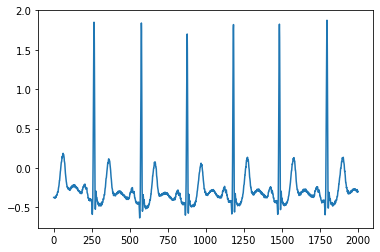

In [17]:
plt.plot(x[0:2000])

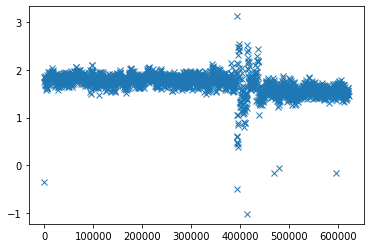

In [18]:
plt.plot(atr_sample[0:2000], x[atr_sample][0:2000], "x")

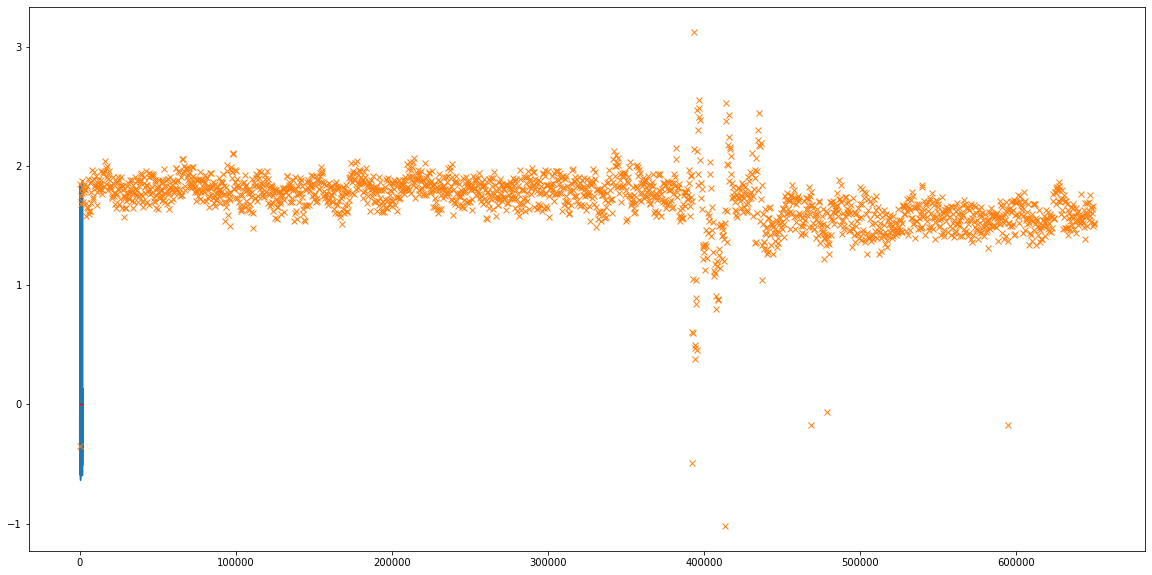

In [36]:
plt.figure(figsize=(20, 10))
plt.plot([i for i in range(0, 2000)], x[0:2000])
plt.plot(atr_sample[0:2091], x[atr_sample], "x")
plt.plot([i for i in range(0, 2000)], [0 for i in range(0, 2000)], "r--")

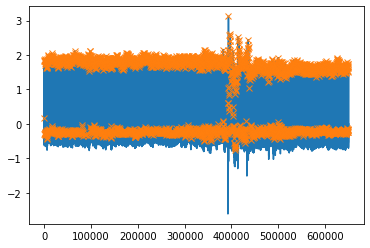

In [26]:
peaks, _ = find_peaks(x, distance=150)
plt.plot(x)
plt.plot(peaks, x[peaks], "x")
plt.show()

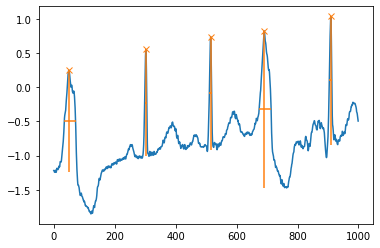

In [55]:
from scipy.misc import electrocardiogram
x = electrocardiogram()[17000:18000]
peaks, properties = find_peaks(x, prominence=1, width=5)
plt.plot(x)
plt.plot(peaks, x[peaks], "x")
plt.vlines(x=peaks, ymin=x[peaks] - properties["prominences"],
           ymax = x[peaks], color = "C1")
plt.hlines(y=properties["width_heights"], xmin=properties["left_ips"],
           xmax=properties["right_ips"], color = "C1")
plt.show()

In [56]:
ecg = p_signal[:, 0][0:2166]

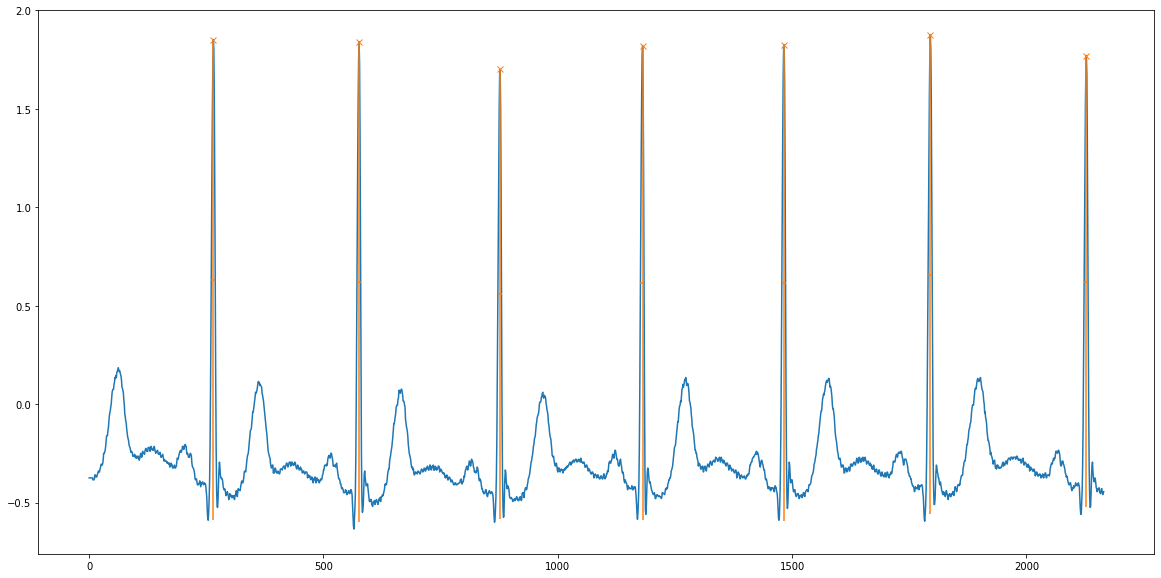

In [64]:
plt.figure(figsize=(20, 10))
plt.plot(ecg)
peaks, properties = find_peaks(ecg, prominence=1, width=1)
plt.plot(peaks[:2166], ecg[peaks], "x")
plt.vlines(x=peaks, ymin=ecg[peaks] - properties["prominences"],
           ymax = ecg[peaks], color = "C1")
plt.hlines(y=properties["width_heights"], xmin=properties["left_ips"],
           xmax=properties["right_ips"], color = "C1")
plt.show()

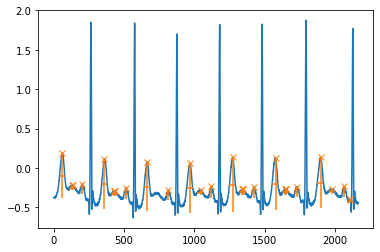

In [65]:
peaks, properties = find_peaks(ecg, width=10)
plt.plot(ecg)
plt.plot(peaks, ecg[peaks], "x")
plt.vlines(x=peaks, ymin=ecg[peaks] - properties["prominences"],
           ymax = ecg[peaks], color = "C1")
plt.hlines(y=properties["width_heights"], xmin=properties["left_ips"],
           xmax=properties["right_ips"], color = "C1")
plt.show()

In [33]:
find_peaks(ecg, width=20)

(array([  62,  132,  139,  205,  361,  428,  432,  439,  516,  666,  968,
        1049, 1122, 1273, 1337, 1345, 1349, 1424, 1578, 1643, 1651, 1656,
        1732, 1902, 1979]),
 {'prominences': array([0.57 , 0.07 , 0.07 , 0.12 , 0.64 , 0.06 , 0.06 , 0.06 , 0.15 ,
         0.625, 0.635, 0.075, 0.145, 0.695, 0.075, 0.075, 0.075, 0.14 ,
         0.66 , 0.08 , 0.08 , 0.08 , 0.135, 0.645, 0.065]),
  'left_bases': array([  10,  107,  107,  184,  274,  406,  406,  406,  491,  583,  884,
         1011, 1101, 1188, 1311, 1311, 1311, 1401, 1490, 1612, 1612, 1612,
         1707, 1804, 1936]),
  'right_bases': array([ 254,  178,  178,  254,  565,  478,  478,  478,  565,  865, 1170,
         1089, 1170, 1472, 1389, 1389, 1389, 1472, 1783, 1707, 1707, 1707,
         1783, 2116, 2031]),
  'widths': array([37.5       , 23.66666667, 23.66666667, 20.5       , 39.51428571,
         23.66666667, 23.66666667, 23.66666667, 27.75      , 37.875     ,
         41.80357143, 35.        , 20.125     , 41.6       ,

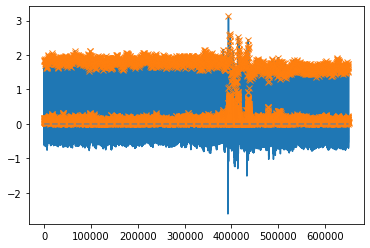

In [34]:
peaks, _ = find_peaks(x, height=0)
plt.plot(x)
plt.plot(peaks, x[peaks], "x")
plt.plot(np.zeros_like(x), "--", color="gray")
plt.show()

In [35]:


plt.figure(figsize=(20, 10))
plt.plot([i for i in range(0, 2000)], BWR.fix_baseline_wander(data, sr=200)[0:2000])
plt.plot([i for i in range(0, 2000)], [0 for i in range(0, 2000)], "r--")

NameError: ignored

<Figure size 1440x720 with 0 Axes>

In [ ]:


sos = signal.butter(1, 40, 'hp', fs=360, output='sos')

In [ ]:
bwr_data = BWR.fix_baseline_wander(data, sr=300)

NameError: ignored

In [ ]:
filtered_data = signal.sosfilt(sos, bwr_data)

In [ ]:

sos = signal.butter(1, 40, 'hp', fs=360, output='sos')
filtered_data = signal.sosfilt(sos, bwr_data)

plt.figure(figsize=(20, 10))
plt.plot([i for i in range(0, 2000)], filtered_data[0:2000])
plt.plot([i for i in range(0, 2000)], [0 for i in range(0, 2000)], "r--")

In [ ]:


wavelet_type='db8'
DWTcoeffs = pywt.wavedec(filtered_data[:301],wavelet_type, level=4, axis=-1)

A4, D4, D3, D2, D1 = DWTcoeffs
features = np.concatenate((A4, D4, D3))

In [ ]:
len(data)

650000

In [ ]:
len(DWTcoeffs), len(DWTcoeffs[0])

(5, 32)

In [ ]:
DWTcoeffs = pywt.wavedec(filtered_data[:301],wavelet_type, level=4, axis=-1)
A4, D4, D3, D2, D1 = DWTcoeffs
features = np.concatenate((A4, D4, D3))

In [ ]:
len(A4)*3

96

In [ ]:
features = np.concatenate((A4, D4, D3))

In [ ]:



X = pd.DataFrame()
X.append(pd.Series(features), ignore_index=True)

,0,1,2,3,4,5,6,7,8,9,...,104,105,106,107,108,109,110,111,112,113
0,-0.105591,-0.091069,-0.039577,-0.133222,-0.06178,-0.056754,-0.141391,-0.040656,-0.078145,-0.134007,...,0.006666,0.001938,0.002613,-0.003197,0.003096,-0.005159,-0.00246,-0.007846,0.001955,0.00784


In [ ]:
features = np.concatenate((A4, D4, D3))
print(len(features))

114


In [ ]:
plt.plot(A4)

NameError: ignored

In [ ]:
plt.plot(D4)

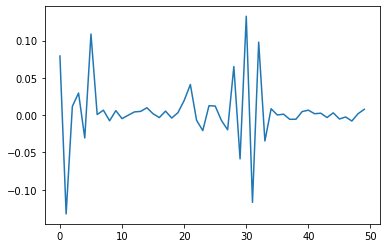

In [ ]:
plt.plot(D3)

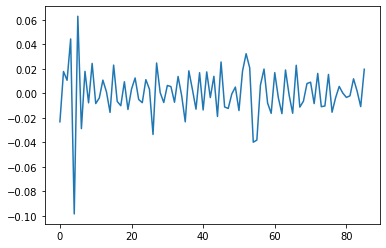

In [ ]:
plt.plot(D2)

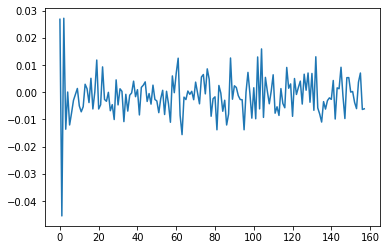

In [ ]:
plt.plot(D1)

In [ ]:
values, counts = np.unique(sym, return_counts=True)
for v,c in zip(values, counts):
    print(v,c)

+ 3
J 50
N 2700
V 3
~ 8


Let's make a plot of these, zooming in on one of the abnormal beats

In [ ]:
nonbeat + abnormal

['[',
 '!',
 ']',
 'x',
 '(',
 ')',
 'p',
 't',
 'u',
 '`',
 "'",
 '^',
 '|',
 '~',
 '+',
 's',
 'T',
 '*',
 'D',
 '=',
 '"',
 '@',
 'Q',
 '?',
 'L',
 'R',
 'V',
 '/',
 'A',
 'f',
 'F',
 'j',
 'a',
 'E',
 'J',
 'e',
 'S']

In [ ]:
pd.Series().append(pd.Series(1))

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  """Entry point for launching an IPython kernel.


0    1
dtype: int64

In [ ]:
def make_dataset():
  X = pd.DataFrame()
  y = pd.DataFrame()

  for pt in id_list:
    file = data_path + pt
    p_signal, atr_sym, atr_sample = load_ecg(file)

    # list of nonbeat and abnormal
    nonbeat_list = ['[','!',']','x','(',')','p','t','u','`',
              '\'','^','|','~','+','s','T','*','D','=','"','@','Q','?']
    abnormal_list = ['L','R','V','/','A','f','F','j','a','E','J','e','S', 'P']
    
    index_list = [b for a,b in zip(atr_sym,atr_sample) if a in abnormal + ["N"]]

    for index in index_list:
      left = index - 100
      right = index + 100

      segment = p_signal[left:right, 0]
      bwr_segment = BWR.fix_baseline_wander(segment, sr=200)
      sos = signal.butter(1, 40, 'hp', fs=360, output='sos')
      filtered_segment = signal.sosfilt(sos, bwr_segment)

      wavelet_type='db8'
      DWTcoeffs = pywt.wavedec(filtered_segment, wavelet_type, level=4, axis=-1)
      A4, D4, D3, D2, D1 = DWTcoeffs

      features = pd.Series(np.concatenate((A4, D4, D3)))
      label = pd.Series([atr_sym[index]])

      X.append(features)
      y.append(label)

      return X, y


In [ ]:
!pip freeze

In [ ]:
"""from tqdm import tqdm
X = pd.DataFrame()
y = pd.DataFrame()

for pt in tqdm(id_list):
  file = data_path + pt
  
  p_signal, atr_sym, atr_sample = load_ecg(file)


  # list of nonbeat and abnormal
  nonbeat_list = ['[','!',']','x','(',')','p','t','u','`',
            '\'','^','|','~','+','s','T','*','D','=','"','@','Q','?']
  abnormal_list = ['L','R','V','/','A','f','F','j','a','E','J','e','S', 'P']
  
  index_list = [b for a,b in zip(atr_sym,atr_sample) if a in abnormal + ["N"]]

  for index in index_list[1:]:
    left = index - 100
    right = index + 200
    
    segment = p_signal[left:right, 0]
    bwr_segment = BWR.fix_baseline_wander(segment, sr=200)
    sos = signal.butter(1, 40, 'hp', fs=360, output='sos')
    filtered_segment = signal.sosfilt(sos, bwr_segment)

    wavelet_type='db8'
    DWTcoeffs = pywt.wavedec(filtered_segment, wavelet_type, level=4, axis=-1)
    A4, D4, D3, D2, D1 = DWTcoeffs

    features = pd.Series(np.concatenate((A4, D4, D3)))
    label = pd.Series([atr_sym[np.where(atr_sample == index)[0][0]]])

    X = X.append(features, ignore_index=True)
    y = y.append(label, ignore_index=True)"""

'from tqdm import tqdm\nX = pd.DataFrame()\ny = pd.DataFrame()\n\nfor pt in tqdm(pts):\n  file = data_path + pt\n  \n  p_signal, atr_sym, atr_sample = load_ecg(file)\n\n\n  # list of nonbeat and abnormal\n  nonbeat_list = [\'[\',\'!\',\']\',\'x\',\'(\',\')\',\'p\',\'t\',\'u\',\'`\',\n            \'\'\',\'^\',\'|\',\'~\',\'+\',\'s\',\'T\',\'*\',\'D\',\'=\',\'"\',\'@\',\'Q\',\'?\']\n  abnormal_list = [\'L\',\'R\',\'V\',\'/\',\'A\',\'f\',\'F\',\'j\',\'a\',\'E\',\'J\',\'e\',\'S\', \'P\']\n  \n  index_list = [b for a,b in zip(atr_sym,atr_sample) if a in abnormal + ["N"]]\n\n  for index in index_list[1:]:\n    left = index - 100\n    right = index + 200\n    \n    segment = p_signal[left:right, 0]\n    bwr_segment = BWR.fix_baseline_wander(segment, sr=200)\n    sos = signal.butter(1, 40, \'hp\', fs=360, output=\'sos\')\n    filtered_segment = signal.sosfilt(sos, bwr_segment)\n\n    wavelet_type=\'db8\'\n    DWTcoeffs = pywt.wavedec(filtered_segment, wavelet_type, level=4, axis=-1)\n    A4, D

In [ ]:
len(X)

0

In [ ]:
X.isnull().any(axis=1).sum()

0

In [ ]:
X

""


In [ ]:
#X.to_csv("Features.csv")

In [ ]:
#y.to_csv("Labels.csv")

In [ ]:
!pwd

/content/drive/MyDrive/datasets/mit-bih-arrhythmia-database-1.0.0


In [ ]:
X = pd.read_csv("/content/drive/MyDrive/datasets/mit-bih-arrhythmia-database-1.0.0/Features.csv")
y = pd.read_csv("/content/drive/MyDrive/datasets/mit-bih-arrhythmia-database-1.0.0/Labels.csv")

In [ ]:
len(X) == len(y)

True

In [ ]:
len(y)

109413

In [ ]:
X.isnull().any(axis=1).sum()

30

In [ ]:
X_ = X[~ X.isnull().any(axis=1)]
y_ = y[~ X.isnull().any(axis=1)]

In [ ]:
X_.isnull().any().any()

False

In [ ]:
len(X_)

109383

In [ ]:
le = preprocessing.LabelEncoder()

In [ ]:
y_.columns

Index(['Unnamed: 0', '0'], dtype='object')

In [ ]:
y_["0"] = le.fit_transform(y_["0"])

In [ ]:
le_dict = dict(zip(le.classes_, le.transform(le.classes_)))

In [ ]:
le_decoded_list = ["" 
                   "Aterial ",
                   "ksk"
]

In [ ]:
y_["0"]

0         6
1         6
2         6
3         6
4         6
         ..
109408    6
109409    6
109410    6
109411    6
109412    6
Name: 0, Length: 109383, dtype: int64

In [ ]:
le.classes_

array(['/', 'A', 'E', 'F', 'J', 'L', 'N', 'R', 'S', 'V', 'a', 'e', 'f',
       'j'], dtype=object)

In [ ]:
le.inverse_transform(le.classes_)

In [ ]:
y_

In [ ]:
X_

,Unnamed: 0,0,1,2,3,4,5,6,7,8,...,104,105,106,107,108,109,110,111,112,113
0,0,-0.030866,-0.028724,-0.011237,-0.034910,-0.019827,-0.019068,-0.039833,-0.015360,-0.023653,...,-0.003272,0.000558,-0.007339,-0.011322,0.020229,-0.001146,-0.000275,0.001434,-0.003160,0.006277
1,1,-0.040595,-0.035016,-0.023343,-0.046994,-0.027808,-0.027257,-0.049094,-0.022516,-0.032750,...,0.001009,-0.002207,-0.013121,0.001112,0.005959,0.010091,-0.002753,0.002840,0.001841,-0.006089
2,2,-0.042023,-0.044820,-0.029205,-0.046762,-0.038867,-0.033574,-0.047183,-0.033664,-0.039810,...,0.013014,-0.006383,-0.009629,-0.001831,0.008396,0.007767,-0.004050,-0.010008,0.007582,-0.000487
3,3,-0.039438,-0.032722,-0.023109,-0.047609,-0.025463,-0.026382,-0.049767,-0.020351,-0.031508,...,-0.001816,0.005478,-0.005622,0.005219,-0.004600,0.004228,-0.005485,0.012284,0.014952,0.006117
4,4,-0.043054,-0.042713,-0.026510,-0.048220,-0.035295,-0.031998,-0.050297,-0.029941,-0.038065,...,-0.001054,-0.004212,-0.005007,-0.005358,0.010740,0.001981,0.003907,-0.000523,0.001692,-0.004457
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
109408,109408,-0.043055,-0.032286,-0.008420,-0.050198,-0.018959,-0.017194,-0.055202,-0.009649,-0.026822,...,-0.008163,0.016061,0.000178,-0.011523,0.015680,-0.013873,-0.005626,0.014940,-0.007267,-0.012305
109409,109409,-0.043023,-0.040537,-0.030125,-0.051174,-0.036387,-0.028783,-0.046374,-0.028230,-0.038334,...,-0.032671,-0.001716,0.007283,-0.001700,-0.001506,-0.004036,0.019343,0.015427,-0.027098,0.011245
109410,109410,-0.034893,-0.033990,-0.027626,-0.040256,-0.031515,-0.026807,-0.037283,-0.026597,-0.032572,...,-0.017290,0.022589,0.030945,-0.009799,-0.004389,-0.036069,0.003044,0.017544,-0.006785,0.006392
109411,109411,-0.033150,-0.029210,-0.013862,-0.037316,-0.020679,-0.020880,-0.042050,-0.016437,-0.025194,...,-0.003647,-0.019774,0.013721,-0.001328,-0.004545,-0.001915,0.023282,-0.010563,0.003813,0.003407


In [ ]:
#y = pd.DataFrame(le.fit_transform(y))

In [ ]:
len(y_["0"].unique())

14

In [ ]:
X_

,Unnamed: 0,0,1,2,3,4,5,6,7,8,...,104,105,106,107,108,109,110,111,112,113
0,0,-0.030866,-0.028724,-0.011237,-0.034910,-0.019827,-0.019068,-0.039833,-0.015360,-0.023653,...,-0.003272,0.000558,-0.007339,-0.011322,0.020229,-0.001146,-0.000275,0.001434,-0.003160,0.006277
1,1,-0.040595,-0.035016,-0.023343,-0.046994,-0.027808,-0.027257,-0.049094,-0.022516,-0.032750,...,0.001009,-0.002207,-0.013121,0.001112,0.005959,0.010091,-0.002753,0.002840,0.001841,-0.006089
2,2,-0.042023,-0.044820,-0.029205,-0.046762,-0.038867,-0.033574,-0.047183,-0.033664,-0.039810,...,0.013014,-0.006383,-0.009629,-0.001831,0.008396,0.007767,-0.004050,-0.010008,0.007582,-0.000487
3,3,-0.039438,-0.032722,-0.023109,-0.047609,-0.025463,-0.026382,-0.049767,-0.020351,-0.031508,...,-0.001816,0.005478,-0.005622,0.005219,-0.004600,0.004228,-0.005485,0.012284,0.014952,0.006117
4,4,-0.043054,-0.042713,-0.026510,-0.048220,-0.035295,-0.031998,-0.050297,-0.029941,-0.038065,...,-0.001054,-0.004212,-0.005007,-0.005358,0.010740,0.001981,0.003907,-0.000523,0.001692,-0.004457
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
109408,109408,-0.043055,-0.032286,-0.008420,-0.050198,-0.018959,-0.017194,-0.055202,-0.009649,-0.026822,...,-0.008163,0.016061,0.000178,-0.011523,0.015680,-0.013873,-0.005626,0.014940,-0.007267,-0.012305
109409,109409,-0.043023,-0.040537,-0.030125,-0.051174,-0.036387,-0.028783,-0.046374,-0.028230,-0.038334,...,-0.032671,-0.001716,0.007283,-0.001700,-0.001506,-0.004036,0.019343,0.015427,-0.027098,0.011245
109410,109410,-0.034893,-0.033990,-0.027626,-0.040256,-0.031515,-0.026807,-0.037283,-0.026597,-0.032572,...,-0.017290,0.022589,0.030945,-0.009799,-0.004389,-0.036069,0.003044,0.017544,-0.006785,0.006392
109411,109411,-0.033150,-0.029210,-0.013862,-0.037316,-0.020679,-0.020880,-0.042050,-0.016437,-0.025194,...,-0.003647,-0.019774,0.013721,-0.001328,-0.004545,-0.001915,0.023282,-0.010563,0.003813,0.003407


In [ ]:
X_ = X_.reset_index(drop=True)

In [ ]:
#X_ = X_.drop(["Unnamed: 0"], axis=1)

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X_, y_["0"], test_size=0.2)

In [ ]:
y_train

18043     6
50675     6
4958      0
106744    6
81579     6
         ..
74098     6
31617     6
63490     6
45346     6
43109     6
Name: 0, Length: 87506, dtype: int64

In [ ]:
"""
clf = make_pipeline(StandardScaler(), SVC(gamma='auto', verbose=True))
clf.fit(X_train, y_train)"""

"\nclf = make_pipeline(StandardScaler(), SVC(gamma='auto', verbose=True))\nclf.fit(X_train, y_train)"

In [ ]:
filename = 'finalized_model.sav'
import pickle

#pickle.dump(clf, open(filename, 'wb'))

In [ ]:
clf = pickle.load(open(filename, "rb"))

In [ ]:
X_ = X_.reset_index(drop=True)
X_train, X_test, y_train, y_test = train_test_split(X_, y_["0"], test_size=1.0)

In [ ]:
X_test

,Unnamed: 0,0,1,2,3,4,5,6,7,8,...,104,105,106,107,108,109,110,111,112,113
100927,100955,0.004592,0.008363,0.009711,0.006761,0.010884,0.005603,0.001376,0.009056,0.008328,...,0.006797,-0.003395,-0.004510,0.000884,0.001244,0.005230,-0.001012,0.010177,0.029183,-0.016492
16794,16798,-0.106177,-0.084816,-0.037972,-0.124311,-0.056976,-0.055885,-0.135236,-0.038780,-0.074589,...,0.036242,0.041206,0.059387,0.010308,-0.049758,-0.056025,-0.027989,-0.025091,0.006204,-0.005590
71066,71085,-0.018706,-0.051812,-0.056523,-0.012939,-0.058740,-0.062291,-0.018790,-0.072762,-0.046577,...,0.056701,-0.020428,-0.010182,0.043374,-0.054293,0.035902,-0.019989,-0.029496,-0.000763,-0.133597
89764,89788,-0.004239,0.000668,-0.002916,-0.006802,0.000233,-0.000046,-0.004810,0.001736,-0.001481,...,-0.003387,0.007586,0.033952,0.003660,-0.024754,-0.024188,0.006914,-0.004093,0.003725,0.022736
45819,45831,-0.045050,-0.031368,-0.003709,-0.060991,-0.012357,-0.016135,-0.070341,-0.002228,-0.025362,...,0.024162,-0.023060,0.005170,0.005557,-0.009487,0.008494,0.007565,-0.031335,0.015609,0.001595
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
101898,101927,-0.019086,-0.016522,-0.009434,-0.023379,-0.012227,-0.011556,-0.024224,-0.008899,-0.015269,...,0.009277,-0.037199,0.022083,0.014221,-0.030925,0.009046,0.032637,-0.007180,0.055462,-0.010179
70410,70429,-0.038239,-0.031160,-0.020594,-0.043268,-0.023922,-0.025277,-0.046899,-0.019740,-0.029139,...,0.015242,0.025692,-0.016885,0.000747,0.007323,-0.001489,-0.030017,0.008451,0.025934,0.014270
98922,98949,-0.028285,-0.026157,-0.019999,-0.033207,-0.021964,-0.022223,-0.034515,-0.019241,-0.025216,...,0.000580,0.004174,0.013243,-0.000010,-0.007614,-0.010819,0.000488,-0.003746,0.005434,0.018347
78477,78498,-0.170526,-0.159768,-0.100814,-0.193815,-0.131100,-0.117580,-0.198169,-0.106916,-0.144234,...,0.010702,-0.033035,-0.000653,-0.020930,0.031812,0.003206,0.024760,-0.030516,-0.004355,-0.018181


In [ ]:
le_dict.keys()

dict_keys(['/', 'A', 'E', 'F', 'J', 'L', 'N', 'R', 'S', 'V', 'a', 'e', 'f', 'j'])

In [ ]:
#y_pred = clf.predict(X_test)

In [ ]:

res = []
for l in list(np.unique(y_pred)):
    prec,recall,_,_ = precision_recall_fscore_support(np.array(y_test)==l,
                                                      np.array(y_pred)==l,
                                                      pos_label=True,average=None)
    res.append([l,recall[0],recall[1]])

In [ ]:
y_test.value_count

AttributeError: ignored

In [ ]:
pd.DataFrame(res,columns = ['class','sensitivity','specificity'])

,class,sensitivity,specificity
0,0,0.999512,0.994982
1,1,0.999205,0.747454
2,2,0.999954,0.920000
3,3,0.999724,0.677632
4,5,0.999161,0.982032
5,6,0.944888,0.999066
6,7,0.999362,0.959005
7,9,0.998289,0.940225
8,10,1.000000,0.043478
9,12,0.999861,0.890909


In [ ]:
df_prec = classification_report(y_test, y_pred, target_names=list(le_dict.keys()))

In [ ]:
df_prec

'              precision    recall  f1-score   support\n\n           /       0.99      0.99      0.99      1395\n           A       0.96      0.75      0.84       491\n           E       0.96      0.92      0.94        25\n           F       0.94      0.68      0.79       152\n           J       0.00      0.00      0.00        17\n           L       0.99      0.98      0.99      1614\n           N       0.98      1.00      0.99     14982\n           R       0.99      0.96      0.97      1488\n           S       0.00      0.00      0.00         1\n           V       0.97      0.94      0.96      1422\n           a       1.00      0.04      0.08        23\n           e       0.00      0.00      0.00         4\n           f       0.98      0.89      0.94       220\n           j       0.00      0.00      0.00        43\n\n    accuracy                           0.98     21877\n   macro avg       0.70      0.58      0.61     21877\nweighted avg       0.97      0.98      0.98     21877\n'

In [ ]:
print(classification_report(y_test, y_pred, target_names=list(le_dict.keys())))

              precision    recall  f1-score   support

           /       0.99      0.99      0.99      1395
           A       0.96      0.75      0.84       491
           E       0.96      0.92      0.94        25
           F       0.94      0.68      0.79       152
           J       0.00      0.00      0.00        17
           L       0.99      0.98      0.99      1614
           N       0.98      1.00      0.99     14982
           R       0.99      0.96      0.97      1488
           S       0.00      0.00      0.00         1
           V       0.97      0.94      0.96      1422
           a       1.00      0.04      0.08        23
           e       0.00      0.00      0.00         4
           f       0.98      0.89      0.94       220
           j       0.00      0.00      0.00        43

    accuracy                           0.98     21877
   macro avg       0.70      0.58      0.61     21877
weighted avg       0.97      0.98      0.98     21877



/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [ ]:
le_dict = dict(zip(le.classes_, le.transform(le.classes_)))
le_dict

{'/': 0,
 'A': 1,
 'E': 2,
 'F': 3,
 'J': 4,
 'L': 5,
 'N': 6,
 'R': 7,
 'S': 8,
 'V': 9,
 'a': 10,
 'e': 11,
 'f': 12,
 'j': 13}

In [ ]:
#accuracy = clf.score(X_test, y_test)

In [ ]:
accuracy = clf.score(X_test, y_test)
print("Accuracy after wavelet transform:", accuracy*100, "%")

Accuracy after wavelet transform: 98.01618137770261 %


In [ ]:
X_test.to_csv("test_signal.csv")

In [ ]:
clf.predict(X_test)

array([6, 7, 5, ..., 6, 6, 6])

In [ ]:
start_time = time.time()
prediction = clf.predict( X_test[X_test["Unnamed: 0"] == 51599] )
print("Prediction from 37265", prediction[0])
print("Actual Diagnosis is", y_test.loc[51599])
end_time = time.time()
print("Time for diagnosis:", round(end_time - start_time, 2), "seconds")

ValueError: ignored

##Fast ICA and PCA

In [ ]:


transformer = FastICA(n_components=18,
                      random_state=0,
                      whiten = 'unit-variance')

X_transformed = transformer.fit_transform(X_)

In [ ]:
from sklearn.svm import SVC
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import FastICA
from sklearn.decomposition import PCA
import pandas as pd

def predict(model="model_file_path.sav", signal="signal_path.csv"):
  clf = pickle.load(open(model, "rb"))
  transformer = FastICA(n_components=18,
                  random_state=0,
                  whiten = 'unit-variance')
  X_ = pd.read_csv(signal)
  X_transformed = transformer.fit_transform(X_)
  X_ICA = pd.merge(X_, X_transformed, left_index=True, right_index=True)
  pca = PCA(n_components=26)
  X_PCA = pd.DataFrame(pca.fit_transform(X_ICA))

  return clf.predict([X_PCA])

  

In [ ]:
X_transformed = pd.DataFrame(X_transformed)

In [ ]:
X_transformed

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17
0,0.000558,0.000415,-0.000026,0.002632,0.000088,0.002525,0.000475,-0.000535,0.000219,0.000360,0.000761,-0.000810,0.000180,-0.000189,0.000222,0.004942,0.000218,-0.000448
1,0.000975,0.003126,0.000214,0.005325,-0.000493,0.001857,0.000150,0.002414,0.000170,0.000380,-0.001229,0.001546,-0.000229,0.000279,-0.000059,0.004805,0.000347,0.000017
2,0.000832,0.002298,0.000077,0.004899,-0.000182,0.003060,0.000020,0.002322,0.000391,0.000646,-0.000557,0.002215,-0.000478,0.000411,-0.000147,0.004983,0.000202,0.000043
3,0.001111,0.000791,-0.000098,0.004720,-0.000226,0.001722,-0.000485,0.000038,0.000099,-0.000042,-0.000516,-0.001229,-0.000127,0.000315,-0.000166,0.004738,0.000529,0.000218
4,0.001161,-0.000840,-0.000120,0.004545,-0.000133,0.002043,-0.000262,-0.000590,0.000126,-0.000193,0.000482,-0.001970,-0.000238,0.000042,-0.000036,0.004667,0.000470,-0.000192
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
109378,0.000037,0.001712,-0.000166,0.002192,-0.000142,0.000480,-0.001121,0.000198,-0.000350,-0.001955,0.001318,-0.000620,0.000400,-0.000603,0.000366,-0.005953,0.000518,-0.000518
109379,0.000155,-0.001661,0.000413,0.002092,0.000292,0.000361,-0.001172,-0.001525,-0.000628,-0.001682,0.002395,-0.002335,-0.000048,0.000133,-0.000016,-0.006002,0.000206,-0.000145
109380,0.000198,-0.000110,0.000792,0.001800,0.000459,0.000554,-0.001005,-0.000298,-0.000490,-0.000646,0.001460,-0.001177,-0.000043,-0.000846,0.000014,-0.005930,0.000321,-0.000193
109381,-0.000386,0.002520,0.000335,0.000589,0.000100,0.000842,-0.001422,-0.000371,0.000027,-0.000495,0.001147,0.000073,-0.000469,-0.000134,-0.000525,-0.005645,0.000325,-0.000115


In [ ]:
X_

,Unnamed: 0,0,1,2,3,4,5,6,7,8,...,104,105,106,107,108,109,110,111,112,113
0,0,-0.030866,-0.028724,-0.011237,-0.034910,-0.019827,-0.019068,-0.039833,-0.015360,-0.023653,...,-0.003272,0.000558,-0.007339,-0.011322,0.020229,-0.001146,-0.000275,0.001434,-0.003160,0.006277
1,1,-0.040595,-0.035016,-0.023343,-0.046994,-0.027808,-0.027257,-0.049094,-0.022516,-0.032750,...,0.001009,-0.002207,-0.013121,0.001112,0.005959,0.010091,-0.002753,0.002840,0.001841,-0.006089
2,2,-0.042023,-0.044820,-0.029205,-0.046762,-0.038867,-0.033574,-0.047183,-0.033664,-0.039810,...,0.013014,-0.006383,-0.009629,-0.001831,0.008396,0.007767,-0.004050,-0.010008,0.007582,-0.000487
3,3,-0.039438,-0.032722,-0.023109,-0.047609,-0.025463,-0.026382,-0.049767,-0.020351,-0.031508,...,-0.001816,0.005478,-0.005622,0.005219,-0.004600,0.004228,-0.005485,0.012284,0.014952,0.006117
4,4,-0.043054,-0.042713,-0.026510,-0.048220,-0.035295,-0.031998,-0.050297,-0.029941,-0.038065,...,-0.001054,-0.004212,-0.005007,-0.005358,0.010740,0.001981,0.003907,-0.000523,0.001692,-0.004457
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
109378,109408,-0.043055,-0.032286,-0.008420,-0.050198,-0.018959,-0.017194,-0.055202,-0.009649,-0.026822,...,-0.008163,0.016061,0.000178,-0.011523,0.015680,-0.013873,-0.005626,0.014940,-0.007267,-0.012305
109379,109409,-0.043023,-0.040537,-0.030125,-0.051174,-0.036387,-0.028783,-0.046374,-0.028230,-0.038334,...,-0.032671,-0.001716,0.007283,-0.001700,-0.001506,-0.004036,0.019343,0.015427,-0.027098,0.011245
109380,109410,-0.034893,-0.033990,-0.027626,-0.040256,-0.031515,-0.026807,-0.037283,-0.026597,-0.032572,...,-0.017290,0.022589,0.030945,-0.009799,-0.004389,-0.036069,0.003044,0.017544,-0.006785,0.006392
109381,109411,-0.033150,-0.029210,-0.013862,-0.037316,-0.020679,-0.020880,-0.042050,-0.016437,-0.025194,...,-0.003647,-0.019774,0.013721,-0.001328,-0.004545,-0.001915,0.023282,-0.010563,0.003813,0.003407


In [ ]:
X_ICA = pd.merge(X_, X_transformed, left_index=True, right_index=True)

In [ ]:
X_ICA.shape

(109383, 133)

In [ ]:
y_["0"].shape

(109383,)

In [ ]:
y_["0"][X_ICA.index]

KeyError: ignored

In [ ]:
X_ICA.drop(["Unnamed: 0"], axis=1, inplace=True)

In [ ]:

X_train_ICA, X_test_ICA, y_train, y_test = train_test_split(X_ICA, y_["0"], test_size=0.2)

In [ ]:
pd.DataFrame(X_train_ICA)

,0,1,2,3,4,5,6,7,8,9,...,8,9,10,11,12,13,14,15,16,17
64403,-0.023244,-0.030016,-0.034909,-0.024176,-0.034232,-0.031034,-0.020044,-0.035156,-0.030406,-0.026671,...,-0.000096,0.001502,-0.001341,-0.004014,-0.000995,0.000109,-0.000246,-0.001989,-0.001009,-0.000330
101540,-0.030425,-0.029572,-0.022590,-0.035816,-0.026614,-0.022415,-0.033486,-0.021871,-0.027924,-0.036711,...,0.000594,-0.001433,0.000971,-0.002159,0.000629,-0.000581,0.000773,-0.004685,-0.000553,0.001818
42242,-0.066713,-0.052185,-0.031185,-0.078288,-0.037140,-0.040255,-0.085264,-0.028264,-0.049042,-0.076041,...,0.000674,-0.001507,0.005064,0.001129,-0.000421,0.000244,-0.000299,0.002141,-0.000063,0.000210
60745,-0.000272,-0.000232,-0.000002,-0.000235,-0.000919,0.001423,0.001771,0.000255,-0.000215,-0.000529,...,-0.000582,0.001977,-0.005505,0.002513,-0.000393,0.000246,-0.000870,0.000774,-0.000734,-0.000438
27294,-0.025871,-0.015524,-0.008666,-0.031293,-0.008852,-0.011781,-0.034420,-0.004738,-0.015527,-0.031356,...,-0.000016,0.000082,0.000333,-0.002347,-0.000534,0.000466,-0.000100,0.001195,0.000244,0.000759
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13846,-0.053485,-0.056252,-0.035921,-0.058746,-0.048360,-0.042038,-0.059909,-0.041887,-0.049498,-0.057010,...,0.000067,-0.000634,0.000347,-0.001295,0.000275,-0.000380,0.000318,0.003356,-0.000464,0.000158
96010,-0.000251,0.001354,0.000112,0.001759,0.001404,-0.000704,0.000203,0.000123,0.000754,0.003132,...,0.000421,0.000936,-0.001902,0.000799,-0.000868,-0.000203,-0.000909,-0.003564,-0.000177,-0.000454
77852,-0.025564,-0.020101,-0.020159,-0.031033,-0.018492,-0.018084,-0.029102,-0.015165,-0.021577,-0.033470,...,0.000241,0.000547,0.001117,-0.000073,-0.000430,0.000351,-0.000872,-0.002304,-0.000017,0.000019
100483,-0.040988,-0.038682,-0.026342,-0.047116,-0.033071,-0.028455,-0.046226,-0.026712,-0.035658,-0.046827,...,-0.000257,-0.001774,0.000620,-0.001207,0.000420,-0.000268,0.000227,-0.004480,-0.001037,0.001840


In [ ]:
"""from sklearn.svm import SVC
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler

clf = make_pipeline(StandardScaler(), SVC(gamma='auto'))
clf.fit(X_train_ICA, y_train)"""

"from sklearn.svm import SVC\nfrom sklearn.pipeline import make_pipeline\nfrom sklearn.preprocessing import StandardScaler\n\nclf = make_pipeline(StandardScaler(), SVC(gamma='auto'))\nclf.fit(X_train_ICA, y_train)"

In [ ]:
filename = 'finalized_model_ICA.sav'

#pickle.dump(clf, open(filename, 'wb'))

In [ ]:

clf = pickle.load(open(filename, "rb"))

In [ ]:
accuracy = clf.score(X_test_ICA, y_test)

In [ ]:
accuracy

0.9044201672989898

In [ ]:
"""from sklearn.svm import SVC
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler

clf = make_pipeline(StandardScaler(), SVC(gamma='auto'))
clf.fit(X_train_ICA, y_train)"""

In [ ]:
# accuracy = clf.score(X_test_ICA, y_test)

In [ ]:
print(accuracy)

In [ ]:
"""from sklearn.svm import SVC
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler

clf = make_pipeline(StandardScaler(), SVC(gamma='auto'))
clf.fit(X_train_ICA, y_train)"""

Accuracy of Model (WT Features and ICA Features):  97.99 %


In [ ]:
accuracy = clf.score(X_test_ICA, y_test)

In [ ]:
print(f"Accuracy of Model (WT Features and ICA Features): ", round(accuracy*100, 2), "%")

In [ ]:
X_test_ICA

,0,1,2,3,4,5,6,7,8,9,...,8,9,10,11,12,13,14,15,16,17
99691,-0.006884,-0.003916,-0.005685,-0.006578,-0.003546,-0.005923,-0.007805,-0.004108,-0.005220,-0.005607,...,0.001472,0.001215,-0.000831,-0.000002,0.000996,-0.000905,-0.000182,-0.003242,-0.000081,0.000474
49685,-0.004202,-0.003520,0.002594,-0.008670,-0.002073,0.004881,-0.003698,0.003591,-0.001932,-0.009995,...,0.000949,0.000078,-0.012771,-0.000368,0.000437,0.000418,-0.000525,0.001517,0.000403,0.000497
29914,-0.014919,-0.014815,-0.007342,-0.018296,-0.011102,-0.009942,-0.019400,-0.008524,-0.012650,-0.018272,...,0.000175,0.000707,-0.000666,-0.001059,0.000525,-0.000871,0.000439,0.004178,-0.001093,0.000787
105991,-0.070913,-0.066558,-0.028718,-0.080413,-0.048969,-0.041902,-0.085933,-0.036550,-0.055618,-0.074761,...,-0.000917,-0.002661,0.004948,0.001432,0.000609,0.000364,0.000026,-0.004157,-0.001003,-0.000109
62318,-0.000503,0.000091,-0.000419,0.000439,-0.000087,-0.000358,0.000369,-0.000406,-0.000158,0.001530,...,-0.000461,0.001990,-0.000248,-0.003771,0.000494,-0.000081,-0.001592,-0.001618,-0.000275,-0.000044
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
430,-0.043599,-0.042611,-0.029272,-0.051547,-0.036114,-0.032377,-0.051625,-0.030056,-0.038975,-0.052018,...,-0.000059,-0.000100,0.001057,-0.000730,-0.000033,-0.000074,0.000133,0.004868,0.000527,-0.000181
88852,-0.016365,-0.007649,-0.006665,-0.020585,-0.004654,-0.006000,-0.020401,-0.001302,-0.009416,-0.021437,...,-0.000431,0.000242,0.000745,-0.000740,0.000050,0.000401,-0.000399,-0.003571,0.000151,-0.000664
109313,0.001830,-0.000815,-0.009192,0.001435,-0.006093,-0.002984,0.007139,-0.006339,-0.003086,-0.002012,...,0.000347,0.001225,0.002913,-0.000831,0.002137,-0.001270,0.000601,-0.005891,0.000283,-0.000769
1244,-0.036662,-0.031132,-0.020195,-0.042724,-0.024268,-0.024073,-0.045044,-0.019398,-0.029003,-0.042617,...,0.000107,0.000219,0.000145,-0.000698,-0.000405,0.000231,-0.000414,0.004563,0.000374,-0.000234
